<h1>Proof of Case & Use pyMagicStat-Alpha V 0.02</h1>

In [127]:
import sys
import shutil
import os

# Ruta del paquete
PYMAGICSTAT_PATH = r'C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat'

## Limpiar caché de módulos
pycache_path = os.path.join(PYMAGICSTAT_PATH, '__pycache__')
if os.path.exists(pycache_path):
    shutil.rmtree(pycache_path)

# Limpiar módulos cargados previamente
MODULES_TO_CLEAR = [mod for mod in sys.modules if mod.startswith("pyMagicStat")]
for module in MODULES_TO_CLEAR:
    del sys.modules[module]

# Asegurar que el path está correcto
if PYMAGICSTAT_PATH not in sys.path:
    sys.path.append(PYMAGICSTAT_PATH)


In [128]:
# Configuración inicial para cargar el proyecto y limpiar la caché
import sys
import os
from importlib import reload
import shutil

# Para pruebas
import numpy as np
import matplotlib.pyplot as plt

# Ruta al directorio raíz del proyecto (ajusta según tu entorno)
PROJECT_ROOT = r'C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat'

# Asegurarse de que el proyecto está en sys.path
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Limpiar caché de módulos compilados
def clean_pycache():
    for root, dirs, _ in os.walk(PROJECT_ROOT):
        if '__pycache__' in dirs:
            cache_dir = os.path.join(root, '__pycache__')
            shutil.rmtree(cache_dir)
            print(f"Eliminado caché en: {cache_dir}")

clean_pycache()

# Limpiar módulos cargados previamente
MODULES_TO_CLEAR = [
    "pyMagicStat.Classes.distributions",
    "pyMagicStat.Classes.confidence_intervals",
    "pyMagicStat.Classes.nonParametricHTest",
    "pyMagicStat.Classes.orchestrator",
    "pyMagicStat.lib.utils"
]

for mod in MODULES_TO_CLEAR:
    if mod in sys.modules:
        del sys.modules[mod]

# Importar módulos principales con la nueva estructura
import pyMagicStat.lib.utils as utils
import pyMagicStat.Classes.confidence_intervals as ci_mod
import pyMagicStat.Classes.distributions as dist_mod
import pyMagicStat.Classes.nonParametricHTest as nptest_mod
import pyMagicStat.Classes.orchestrator as orch_mod

# Recargar para reflejar cambios en caliente
reload(utils)
reload(ci_mod)
reload(dist_mod)
reload(nptest_mod)
reload(orch_mod)

# Importar las clases nuevas
from pyMagicStat.lib.utils import output_format, plot_distribution_summary
from pyMagicStat.Classes.confidence_intervals import (
    ConfidenceIntervals,
    PopulationMeanCI,
    PopulationVarianceCI,
    PopulationProportionCI,
)
from pyMagicStat.Classes.distributions import (
    Distribution,
    NormalDistribution,
    BinomialDistribution,
    PoissonDistribution,
    LognormalDistribution,
    DistributionValidator,
    ContinuousDistributionValidator,
    DiscreteDistributionValidator,
)
from pyMagicStat.Classes.nonParametricHTest import (
    BootstrapCI,
    kruskalWallisTest,
)
from pyMagicStat.Classes.orchestrator import (
    OptimizedExperimentationIteration,
    StatisticalEvaluator,
)

# Validación del entorno
print("Módulos pyMagicStat cargados con la nueva estructura:")
print(" - utils       :", utils)
print(" - ci_mod      :", ci_mod)
print(" - dist_mod    :", dist_mod)
print(" - nptest_mod  :", nptest_mod)
print(" - orch_mod    :", orch_mod)

# Ejemplo rápido de uso:
# 1) Bootstrap de la media con Numba
data = np.random.normal(0, 1, 500)
ci = BootstrapCI(data, stat='mean', method='numba', alpha=0.05, n_resamples=1000)
print("BootstrapCI mean (numba):", ci.compute())

# 2) Kruskal-Wallis
g1 = np.random.normal(0,1,100)
g2 = np.random.normal(1,1,100)
kw = kruskalWallisTest(g1, g2)
print("Kruskal-Wallis:", kw.run_test())

print("Entorno listo para trabajar.")  


Módulos pyMagicStat cargados con la nueva estructura:
 - utils       : <module 'pyMagicStat.lib.utils' from 'C:\\Users\\ehudb\\OneDrive\\Desktop\\pyMagicStat\\pyMagicStat\\lib\\utils.py'>
 - ci_mod      : <module 'pyMagicStat.Classes.confidence_intervals' from 'C:\\Users\\ehudb\\OneDrive\\Desktop\\pyMagicStat\\pyMagicStat\\Classes\\confidence_intervals.py'>
 - dist_mod    : <module 'pyMagicStat.Classes.distributions' from 'C:\\Users\\ehudb\\OneDrive\\Desktop\\pyMagicStat\\pyMagicStat\\Classes\\distributions.py'>
 - nptest_mod  : <module 'pyMagicStat.Classes.nonParametricHTest' from 'C:\\Users\\ehudb\\OneDrive\\Desktop\\pyMagicStat\\pyMagicStat\\Classes\\nonParametricHTest.py'>
 - orch_mod    : <module 'pyMagicStat.Classes.orchestrator' from 'C:\\Users\\ehudb\\OneDrive\\Desktop\\pyMagicStat\\pyMagicStat\\Classes\\orchestrator.py'>
BootstrapCI mean (numba): {'lb': np.float64(-0.04499943031442139), 'ub': np.float64(0.12894862979581284)}
Kruskal-Wallis: {'H_statistic': 61.977814925373195, 

In [105]:
import sys
print(sys.path)

['C:\\Users\\ehudb\\OneDrive\\Desktop\\pyMagicStat', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\python311.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\ehudb\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages', 'C:\\Users\\ehudb\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\win32', 'C:\\Users\\ehudb\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\ehudb\\AppData\\Lo

In [107]:


def normal_ci_mean(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    stderr = np.std(data, ddof=1) / np.sqrt(n)
    margin = stderr * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean - margin, mean + margin

def bootstrap_ci(data, func=np.mean, confidence=0.95, n_bootstraps=1000):
    bootstraps = np.random.choice(data, (n_bootstraps, len(data)), replace=True)
    stat = np.array([func(sample) for sample in bootstraps])
    lower = np.percentile(stat, (1-confidence)/2*100)
    upper = np.percentile(stat, (1+confidence)/2*100)
    return lower, upper

def audit_precision(data, n_bootstraps=1000, confidence=0.95):
    results = {
        'mean': {'normal': {}, 'bootstrap': {}},
        'variance': {'normal': {}, 'bootstrap': {}},
        'proportion': {'normal': {}, 'bootstrap': {}},
        'median': {'normal': {}, 'bootstrap': {}}
    }
    
    # Media
    results['mean']['normal']['ci'] = normal_ci_mean(data, confidence)
    results['mean']['bootstrap']['ci'] = bootstrap_ci(data, np.mean, confidence, n_bootstraps)
    results['mean']['actual'] = np.mean(data)
    
    # Varianza
    variance_normal = np.var(data, ddof=1)
    ci_variance = (variance_normal - 1.96*np.sqrt(2*variance_normal**2/(len(data)-1)),
                   variance_normal + 1.96*np.sqrt(2*variance_normal**2/(len(data)-1)))
    results['variance']['normal']['ci'] = ci_variance
    results['variance']['bootstrap']['ci'] = bootstrap_ci(data, np.var, confidence, n_bootstraps)
    results['variance']['actual'] = variance_normal
    
    # Proporción Poblacional
    prop = np.mean(data > 0)
    n = len(data)
    se_prop = np.sqrt(prop * (1 - prop) / n)
    z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
    ci_prop = (prop - z_score * se_prop, prop + z_score * se_prop)
    results['proportion']['normal']['ci'] = ci_prop
    results['proportion']['bootstrap']['ci'] = bootstrap_ci(data, lambda x: np.mean(x > 0), confidence, n_bootstraps)
    results['proportion']['actual'] = prop
    
    # Mediana
    results['median']['normal']['ci'] = (np.median(data) - 1.96 * np.std(data) / np.sqrt(len(data)),
                                         np.median(data) + 1.96 * np.std(data) / np.sqrt(len(data)))
    results['median']['bootstrap']['ci'] = bootstrap_ci(data, np.median, confidence, n_bootstraps)
    results['median']['actual'] = np.median(data)
    
    return results

# Generación de datos para diferentes distribuciones




<h3>Lognormal hay que solucionar la falta de presicion en la aproximacion a la normal.</h3>

<h1>Esta Salida solo debe mostrar pruebas positivas de distribucion</h1>

generar una funcion con el bloque anterior para que valide cada una de las instancias de binomial y se cierra ese modulo

<H3>Poisson Distribution</H3>

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd 

#groups = [np.random.poisson(lam=np.random.uniform(1, 5), size=500) for _ in range(20)]
groups = [np.random.poisson(lam=np.random.uniform(1, 5), size=500) for _ in range(10)]
# Crear la instancia del test de Kruskal-Wallis con los 20 grupos


# 2. Configurar la evaluación estadística.
evaluator = StatisticalEvaluator(kruskalWallisTest)

# 3. Configurar el framework experimental:
# Por ejemplo, usando la estrategia "greedy" con un umbral de R² deseado de 0.75.
framework = OptimizedExperimentationIteration(
    evaluator=evaluator,
    groups=groups,
    strategy="exhaustive",
    r2_target=0.75,
    max_iterations=10
)

# 4. Ejecutar la iteración experimental.
result = framework.run()

# Mostrar resultados:
print("Historial de iteraciones:")
for item in framework.history:
    print(item)


#print('Hay que desarollar un metodo grafico eficiente y mensajes de error congruentes ')

Historial de iteraciones:
{'subset_indices': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 'groups': ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7', 'Group 8', 'Group 9', 'Group 10'], 'global_R2': 0.32494412216189816, 'evaluation': {'global_R2': 0.32494412216189816, 'p_value': 0.0, 'results': {'H_statistic': 1693.5367540983739, 'p_value': 0.0, 'df': 9, 'Total_SS': 21940.72, 'Groups': [{'Label': 'Group 1', 'SSW': 1147.158, 'R^2': 0.9477155717770429, 'p_value': 2.394543650064325e-20}, {'Label': 'Group 2', 'SSW': 909.318, 'R^2': 0.9585556900593964, 'p_value': 2.3230968226665814e-34}, {'Label': 'Group 3', 'SSW': 812.328, 'R^2': 0.9629762377898264, 'p_value': 5.213341419797637e-45}, {'Label': 'Group 4', 'SSW': 1826.8319999999997, 'R^2': 0.9167378281113838, 'p_value': 3.5496040144308164e-17}, {'Label': 'Group 5', 'SSW': 566.008, 'R^2': 0.974202852048611, 'p_value': 1.0930015420407996e-109}, {'Label': 'Group 6', 'SSW': 1232.808, 'R^2': 0.943811871260378, 'p_value': 0.001593341

<h3>Poisson trabajar approx a normalidad </h3>

In [ ]:
# Generar datos de prueba
data_normal = np.random.normal(loc=0, scale=1, size=1000)
data_binomial = np.random.binomial(n=10, p=0.5, size=1000)
data_poisson = np.random.poisson(lam=5, size=1000)
data_lognormal = np.random.lognormal(mean=0, sigma=1, size=1000)


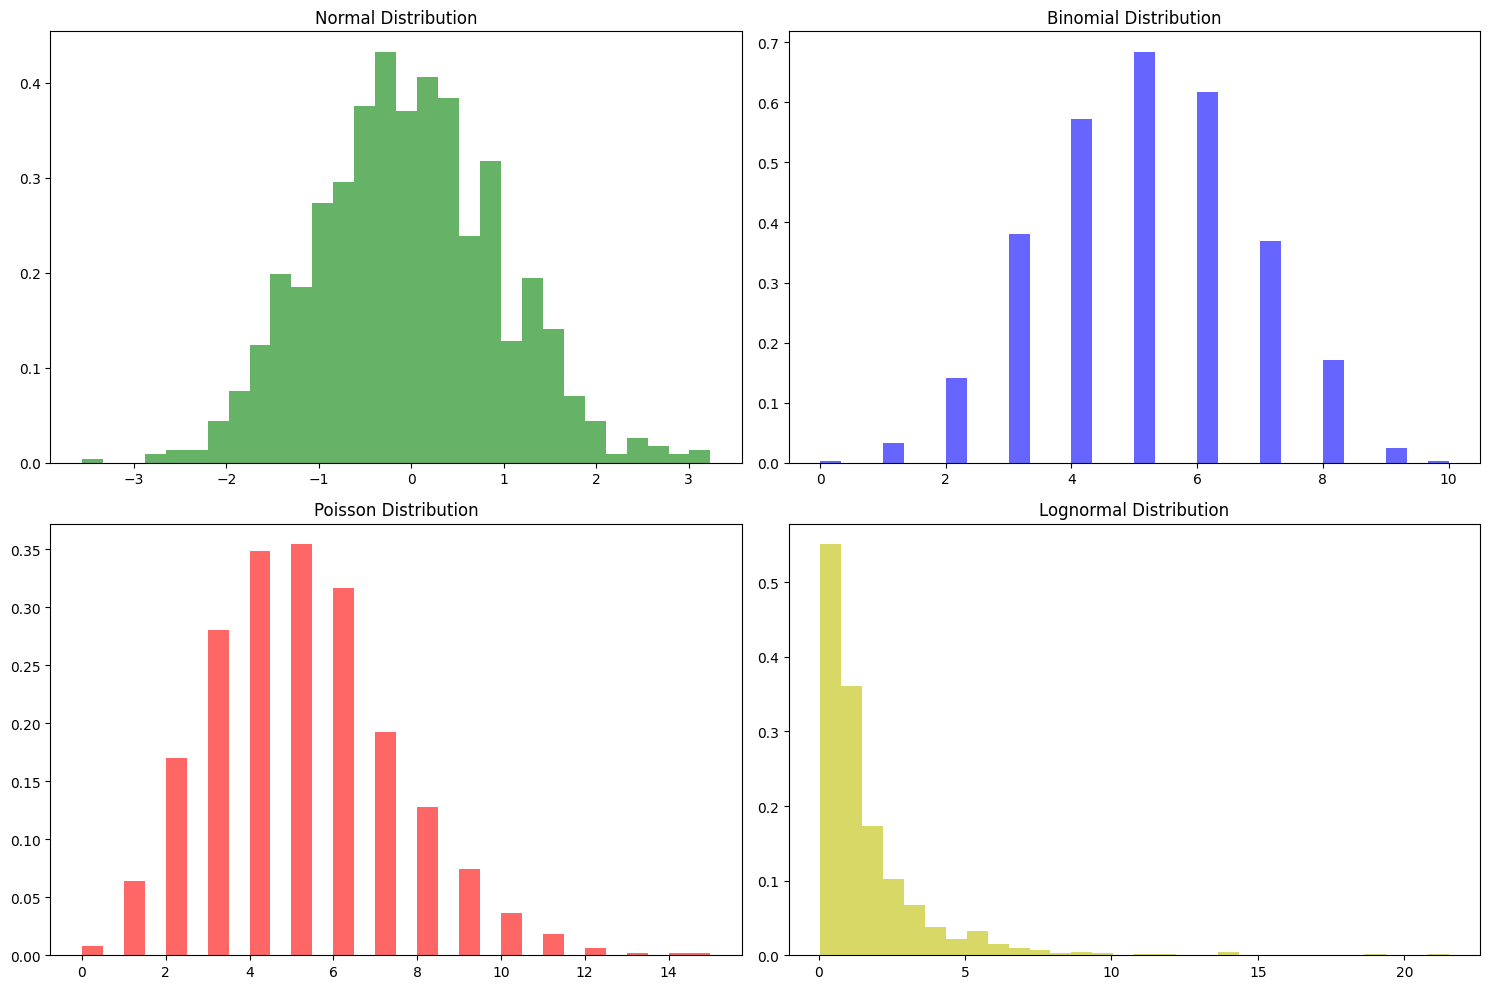

In [ ]:
# Visualizar las distribuciones generadas
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(data_normal, bins=30, density=True, alpha=0.6, color='g')
plt.title('Normal Distribution')

plt.subplot(2, 2, 2)
plt.hist(data_binomial, bins=30, density=True, alpha=0.6, color='b')
plt.title('Binomial Distribution')

plt.subplot(2, 2, 3)
plt.hist(data_poisson, bins=30, density=True, alpha=0.6, color='r')
plt.title('Poisson Distribution')

plt.subplot(2, 2, 4)
plt.hist(data_lognormal, bins=30, density=True, alpha=0.6, color='y')
plt.title('Lognormal Distribution')

plt.tight_layout()
plt.show()


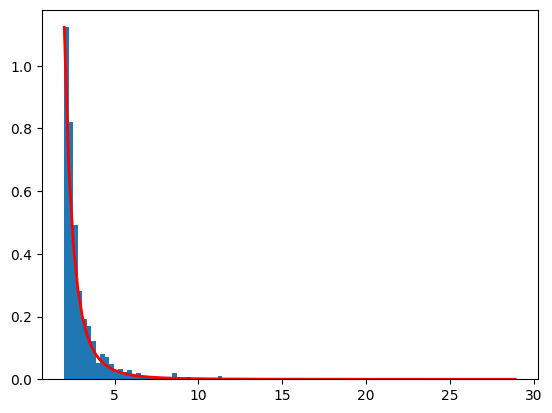

In [ ]:
>>> a, m = 3., 2.  # shape and mode
>>> s = (np.random.pareto(a, 1000) + 1) * m
#Display the histogram of the samples, along with the probability density function:

>>> import matplotlib.pyplot as plt
>>> count, bins, _ = plt.hist(s, 100, density=True)
>>> fit = a*m**a / bins**(a+1)
>>> plt.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
>>> plt.show()

None
1.755692630380942
3.0
{'Poisson': np.True_, 'goodness_of_fit': {'chi2': np.float64(17.963012494955308), 'p_value': np.float64(0.055590782534339814)}}


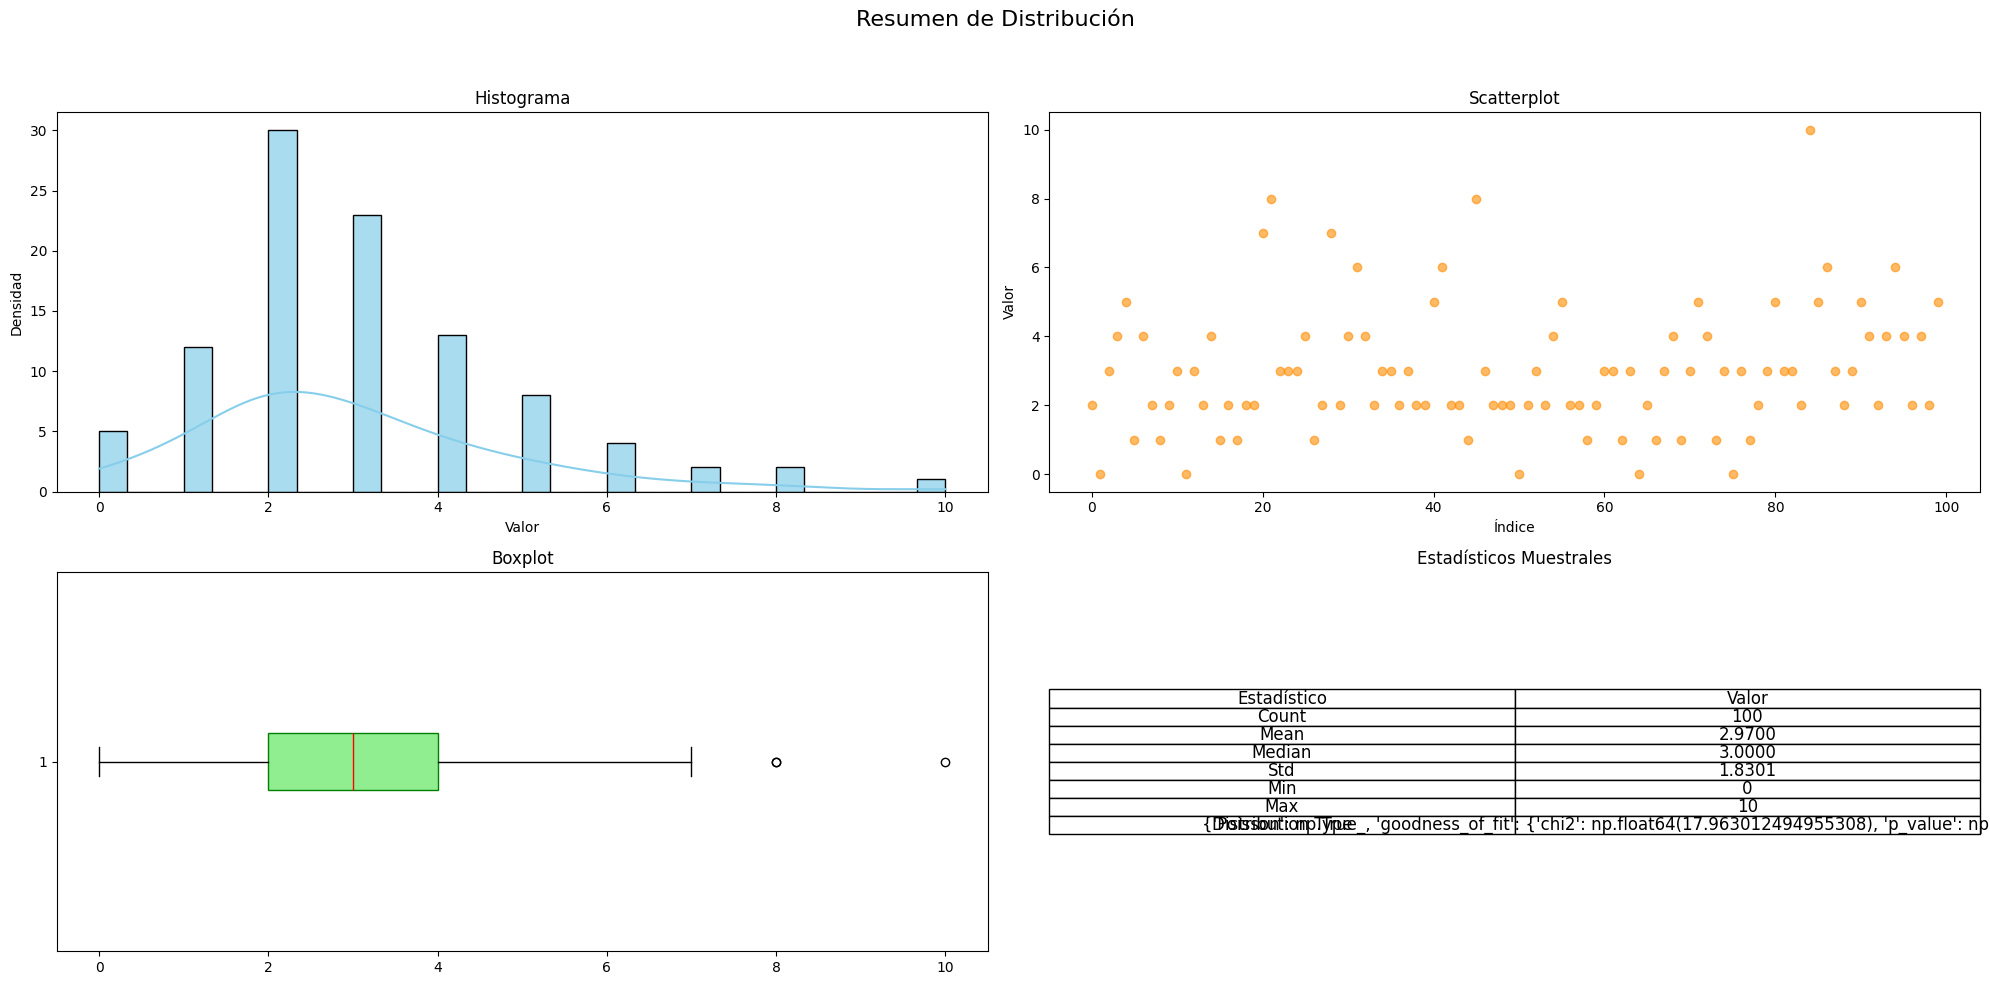

In [ ]:
# cambiar nombre de la clase a singular ! Distribution
data = Distribution(np.random.poisson(lam=3, size=100))
print(data.type)
print(data.kurtosis)
print(data.median)

poisson_test = PoissonDistribution(data)
# creo que este metodo deberia llamarse desde el Init y si la funcion da false que rechace la instancia, en test de bondad de ajuste masivos ahorrara estar instanciando inecesariamente 
poisson_test.validate_data()

# no hay criterio unificado , en todas las clases deberiamos llamar nombres de metodos iguales para que sea mas facil de usar .fit_test()
poisson_test.evaluate_goodness_of_fit()
poisson_test.evaluate_normal_approximation()
print(data.type)

# Falta Implementar test de approximacion normal 
data.distribution_vizualization()

In [ ]:
data = Distribution(np.random.normal(loc=0, scale=1, size=100))
print(data.type)
print(data.kurtosis)
normal_data = NormalDistribution(data)
print(data.type)
# unificar nombre de metodo 
print(normal_data.evaluate_normality())
print(normal_data.assign_weights())
# demasiada info no necesaria , data.type deberia responder implementando output_format from utils.py
print(data.type)



None
0.2083442206018029
None
{'KS': {'statistic': np.float64(0.06342898532550278), 'p_value': np.float64(0.79196681983225)}, 'Shapiro': {'statistic': np.float64(0.989506753014588), 'p_value': np.float64(0.6248422117716566)}, "D'Agostino": {'statistic': np.float64(1.6090823171421795), 'p_value': np.float64(0.44729311609355693)}, 'Anderson': {'statistic': np.float64(0.2743992108620006), 'critical_values': [0.555, 0.632, 0.759, 0.885, 1.053], 'significance_levels': [15.0, 10.0, 5.0, 2.5, 1.0]}, 'QQ': {'slope': np.float64(0.9901564135208389), 'intercept': np.float64(-0.02633391099007491), 'p_value_slope': np.float64(0.3628722792480761), 'p_value_intercept': np.float64(0.014244691342008453)}}
{'KS': 0.2, 'Shapiro': 0.2, "D'Agostino": 0.2, 'Anderson': 0.3, 'QQ': 0.1}
{'Normal': np.True_, 'normality_results': {'KS': {'statistic': np.float64(0.06342898532550278), 'p_value': np.float64(0.79196681983225)}, 'Shapiro': {'statistic': np.float64(0.989506753014588), 'p_value': np.float64(0.6248422117

In [ ]:
data_lognorm = Distribution(np.random.lognormal(mean=0, sigma=1, size=100))
lognorm_data = LognormalDistribution(data_lognorm)
print(data_lognorm.type)
print(lognorm_data.evaluate_normality())
print(lognorm_data.assign_weights())
print(data_lognorm.type)


None
{'KS': {'statistic': np.float64(0.10863733969496164), 'p_value': np.float64(0.17526536046480135)}, 'Shapiro': {'statistic': np.float64(0.9631531602435317), 'p_value': np.float64(0.006790921587887942)}, "D'Agostino": {'statistic': np.float64(10.487274584600522), 'p_value': np.float64(0.005281013270943012)}, 'Anderson': {'statistic': np.float64(1.2848226583599853), 'critical_values': [0.555, 0.632, 0.759, 0.885, 1.053], 'significance_levels': [15.0, 10.0, 5.0, 2.5, 1.0]}, 'QQ': {'slope': np.float64(0.9430899794753496), 'intercept': np.float64(0.033940345114355744), 'p_value_slope': np.float64(0.0036639087134870962), 'p_value_intercept': np.float64(0.07306031294978887)}}
{'KS': 0.2, 'Shapiro': 0.2, "D'Agostino": 0.2, 'Anderson': 0.3, 'QQ': 0.1}
{'Lognormal': True, 'normality_log_results': {'KS': {'statistic': np.float64(0.10863733969496164), 'p_value': np.float64(0.17526536046480135)}, 'Shapiro': {'statistic': np.float64(0.9631531602435317), 'p_value': np.float64(0.006790921587887942

In [ ]:
from pyMagicStat.Classes.nonParametricHTest import BootstrapMeanCI

data = np.random.normal(6, 2, 500000)
bootstrap_ci = BootstrapMeanCI(data, )
interval = bootstrap_ci.calculate_interval()
print("Bootstrap Confidence Interval:", interval)
print(data)
print(data.mean())
print(f"Lower Bound: {interval['lb']}")
prob = bootstrap_ci.probability_in_interval(np.median(data))
print(f"Probabilidad de que 7.5 esté dentro del intervalo: {prob:.4f}")
print("###########################################################")
boostrapMedian = BootstrapMedianCI(data)
interval_median = boostrapMedian.calculate_interval()
print("Bootstrap Confidence Interval:", interval_median)
print(f"mediana muestral{np.median(data)}")

print("#####################################################")
boostrapVariance = BootstrapVarianceCI(data)
interval_variance = boostrapVariance.calculate_interval()
print("Bootstrap Confidence Interval:", interval_variance)
print(f"varianza muestral{np.var(data)}")

print("#####################################################")


ImportError: cannot import name 'BootstrapMeanCI' from 'pyMagicStat.Classes.nonParametricHTest' (C:\Users\ehudb\OneDrive\Desktop\pyMagicStat\pyMagicStat\Classes\nonParametricHTest.py)

<h2>NO BORRR IMPORTANTE PARA OFFICE </h2>

In [ ]:
import numpy as np

# Simulación de datos con algunos outliers
data = np.concatenate([np.random.normal(6, 2, 95), np.array([50, -30, 100])])

# Método IQR para eliminar outliers
q1, q3 = np.percentile(data, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtrar datos sin outliers
filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

print(f"Tamaño original: {len(data)}")
print(f"Tamaño después de eliminar outliers: {len(filtered_data)}")
print(f"Valores filtrados: {set(data) - set(filtered_data)}")


Tamaño original: 98
Tamaño después de eliminar outliers: 94
Valores filtrados: {np.float64(100.0), np.float64(10.617104891705097), np.float64(-30.0), np.float64(50.0)}


<h1>Caso completo NonParametricHTest::BootstrapConfidenceIntervals</h1>

In [122]:
import numpy as np
import matplotlib.pyplot as plt
 # Asegúrate de tener este módulo en tu path

# Parámetros de la simulación
true_mean = 5.0           # Valor verdadero de la media y la mediana (para una normal simétrica)
true_std = 1.0            # Desviación estándar
true_variance = true_std**2  # Varianza verdadera
sample_size = 30          # Tamaño de la muestra en cada simulación
n_simulations = 10000      # Número de simulaciones
alpha = 0.05              # Nivel de significancia para un intervalo del 95%
resamples = 1000          # Número de remuestreos en cada bootstrap

# Variables para almacenar resultados
coverage_mean = 0
coverage_median = 0
coverage_variance = 0

interval_lengths_mean = []
interval_lengths_median = []
interval_lengths_variance = []

for i in range(n_simulations):
    # Generamos una muestra aleatoria de una distribución normal
    sample = np.random.normal(loc=true_mean, scale=true_std, size=sample_size)
    
    # Intervalo bootstrap para la media
    bs_mean = BootstrapMeanCI(sample, alpha=alpha, resamples=resamples)
    ci_mean = bs_mean.calculate_interval()  # Se espera un dict con llaves 'lb' y 'ub'
    if ci_mean['lb'] <= true_mean <= ci_mean['ub']:
        coverage_mean += 1
    interval_lengths_mean.append(ci_mean['ub'] - ci_mean['lb'])
    
    # Intervalo bootstrap para la mediana
    bs_median = BootstrapMedianCI(sample, alpha=alpha, resamples=resamples)
    ci_median = bs_median.calculate_interval()
    # Para una normal simétrica, la mediana es igual a la media
    if ci_median['lb'] <= true_mean <= ci_median['ub']:
        coverage_median += 1
    interval_lengths_median.append(ci_median['ub'] - ci_median['lb'])
    
    # Intervalo bootstrap para la varianza
    bs_variance = BootstrapVarianceCI(sample, alpha=alpha, resamples=resamples)
    ci_variance = bs_variance.calculate_interval()
    if ci_variance['lb'] <= true_variance <= ci_variance['ub']:
        coverage_variance += 1
    interval_lengths_variance.append(ci_variance['ub'] - ci_variance['lb'])

# Calcular la cobertura en porcentaje
coverage_mean_pct = (coverage_mean / n_simulations) * 100
coverage_median_pct = (coverage_median / n_simulations) * 100
coverage_variance_pct = (coverage_variance / n_simulations) * 100

print(f"Porcentaje de cobertura del intervalo de la media: {coverage_mean_pct:.2f}%")
print(f"Porcentaje de cobertura del intervalo de la mediana: {coverage_median_pct:.2f}%")
print(f"Porcentaje de cobertura del intervalo de la varianza: {coverage_variance_pct:.2f}%\n")

print(f"Longitud promedio del intervalo para la media: {np.mean(interval_lengths_mean):.4f}")
print(f"Longitud promedio del intervalo para la mediana: {np.mean(interval_lengths_median):.4f}")
print(f"Longitud promedio del intervalo para la varianza: {np.mean(interval_lengths_variance):.4f}")

# Visualización de histogramas de las longitudes de los intervalos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(interval_lengths_mean, bins=30, edgecolor='black')
axes[0].set_title("Longitudes del CI para la media")
axes[0].set_xlabel("Longitud del intervalo")
axes[0].set_ylabel("Frecuencia")

axes[1].hist(interval_lengths_median, bins=30, edgecolor='black')
axes[1].set_title("Longitudes del CI para la mediana")
axes[1].set_xlabel("Longitud del intervalo")
axes[1].set_ylabel("Frecuencia")

axes[2].hist(interval_lengths_variance, bins=30, edgecolor='black')
axes[2].set_title("Longitudes del CI para la varianza")
axes[2].set_xlabel("Longitud del intervalo")
axes[2].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


NameError: name 'BootstrapMeanCI' is not defined

In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
# from nonParametricHTest import BootstrapMeanCI, BootstrapMedianCI, BootstrapVarianceCI

# Factores a variar en tu diseño
sample_sizes = [30, 100, 300]
resamples_list = [100, 1000, 5000, 10000]  # Incluimos 10,000 aquí
alphas = [0.01, 0.05, 0.1]
n_simulations = 1000  # Ajusta según tu tolerancia de tiempo de cómputo

# Parámetros de la distribución simulada
true_mean = 5.0
true_std = 1.0
true_variance = true_std ** 2

# Lista para guardar resultados
results = []

for (sample_size, resamples, alpha) in itertools.product(sample_sizes, resamples_list, alphas):
    coverage_mean = 0
    coverage_median = 0
    coverage_variance = 0
    
    interval_lengths_mean = []
    interval_lengths_median = []
    interval_lengths_variance = []
    
    for _ in range(n_simulations):
        # Generar la muestra
        sample = np.random.normal(loc=true_mean, scale=true_std, size=sample_size)
        
        # Bootstrap para la media
        bs_mean = BootstrapMeanCI(sample, alpha=alpha, resamples=resamples)
        ci_mean = bs_mean.calculate_interval()
        if ci_mean['lb'] <= true_mean <= ci_mean['ub']:
            coverage_mean += 1
        interval_lengths_mean.append(ci_mean['ub'] - ci_mean['lb'])
        
        # Bootstrap para la mediana
        bs_median = BootstrapMedianCI(sample, alpha=alpha, resamples=resamples)
        ci_median = bs_median.calculate_interval()
        if ci_median['lb'] <= true_mean <= ci_median['ub']:
            coverage_median += 1
        interval_lengths_median.append(ci_median['ub'] - ci_median['lb'])
        
        # Bootstrap para la varianza
        bs_variance = BootstrapVarianceCI(sample, alpha=alpha, resamples=resamples)
        ci_variance = bs_variance.calculate_interval()
        if ci_variance['lb'] <= true_variance <= ci_variance['ub']:
            coverage_variance += 1
        interval_lengths_variance.append(ci_variance['ub'] - ci_variance['lb'])
    
    # Calcular métricas
    coverage_mean_pct = (coverage_mean / n_simulations) * 100
    coverage_median_pct = (coverage_median / n_simulations) * 100
    coverage_variance_pct = (coverage_variance / n_simulations) * 100
    
    avg_len_mean = np.mean(interval_lengths_mean)
    avg_len_median = np.mean(interval_lengths_median)
    avg_len_variance = np.mean(interval_lengths_variance)
    
    # Guardar en la lista de resultados
    results.append({
        'sample_size': sample_size,
        'resamples': resamples,
        'alpha': alpha,
        'coverage_mean': coverage_mean_pct,
        'coverage_median': coverage_median_pct,
        'coverage_variance': coverage_variance_pct,
        'len_mean': avg_len_mean,
        'len_median': avg_len_median,
        'len_variance': avg_len_variance
    })

df_results = pd.DataFrame(results)
print(df_results)

# Ejemplo de cómo podrías analizar o graficar un subset
pivot_coverage_mean = df_results.pivot_table(values='coverage_mean', 
                                             index='resamples', 
                                             columns='sample_size')
pivot_coverage_mean.plot(kind='bar', figsize=(8,5))
plt.title('Cobertura de la Media (Bootstrap) según resamples y sample_size')
plt.ylabel('Cobertura (%)')
plt.show()


NameError: name 'BootstrapMeanCI' is not defined

prueba test poisson{'chi2': np.float64(63.97506280431727), 'p_value': np.float64(4.59066834734751e-07)}
False


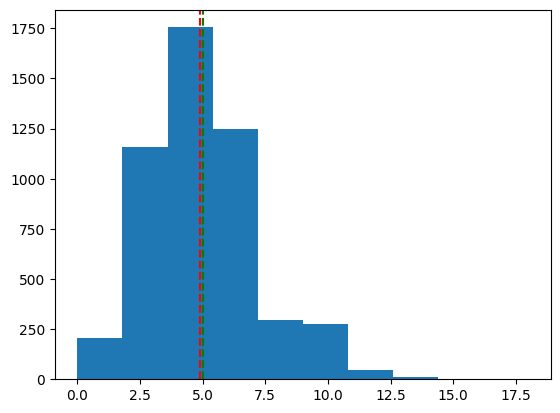

intervalos de confianza calculados con bootstrap4.8958 5.0172099999999995
intervalo de confianza uzando media poblacional T {'lb': np.float64(4.894825866988681), 'ub': np.float64(5.01877413301132), 'Result': np.True_, 'txt': 'Confidence Interval for the mean calculated propperly'}


In [ ]:
poisson_no_normal = np.random.poisson(lam=5, size=5000)
dist = Distribution(poisson_no_normal)
test_dist_poisson = PoissonDistribution(dist) 
test_dist_poisson.validate_data()
print(f'prueba test poisson{test_dist_poisson.evaluate_goodness_of_fit()}')
print(test_dist_poisson.evaluate_normal_approximation())
poisson_test = BootstrapCI(poisson_no_normal, alpha=0.05, n_resamples=5000, stat='mean', method='scipy')
x = poisson_test.compute()
plt.hist(poisson_test.data)
plt.axvline(x=x['lb'], color='r', linestyle='--')
plt.axvline(x=x['ub'], color='g', linestyle='--')
plt.show()
print(f"intervalos de confianza calculados con bootstrap {x['lb']} {x['ub']}")

print(f"intervalo de confianza uzando media poblacional T {PopulationMeanCI(poisson_no_normal, alpha=0.05).calculate_interval()}")


In [138]:
dist.type

{'Poisson': np.True_,
 'goodness_of_fit': {'chi2': np.float64(27.211769136981253),
  'p_value': np.float64(0.05503423581481401)}}

In [139]:
dist


            Distribution Summary:
            count=5000,
            type={'Poisson': np.True_, 'goodness_of_fit': {'chi2': np.float64(27.211769136981253), 'p_value': np.float64(0.05503423581481401)}},
            stats:
            mean=4.9786,
            std=2.2226430302682436,
            var=4.9401420400000005,
            skewness=0.4535964277375612,
            kurtosis=0.27223728534500236,
            median=5.0,
            mode=ModeResult(mode=np.int32(5), count=np.int64(893)),
            min=0,
            max=17,
            q1=3.0,
            q3=6.0,
            iqr=3.0,
            range=17
        

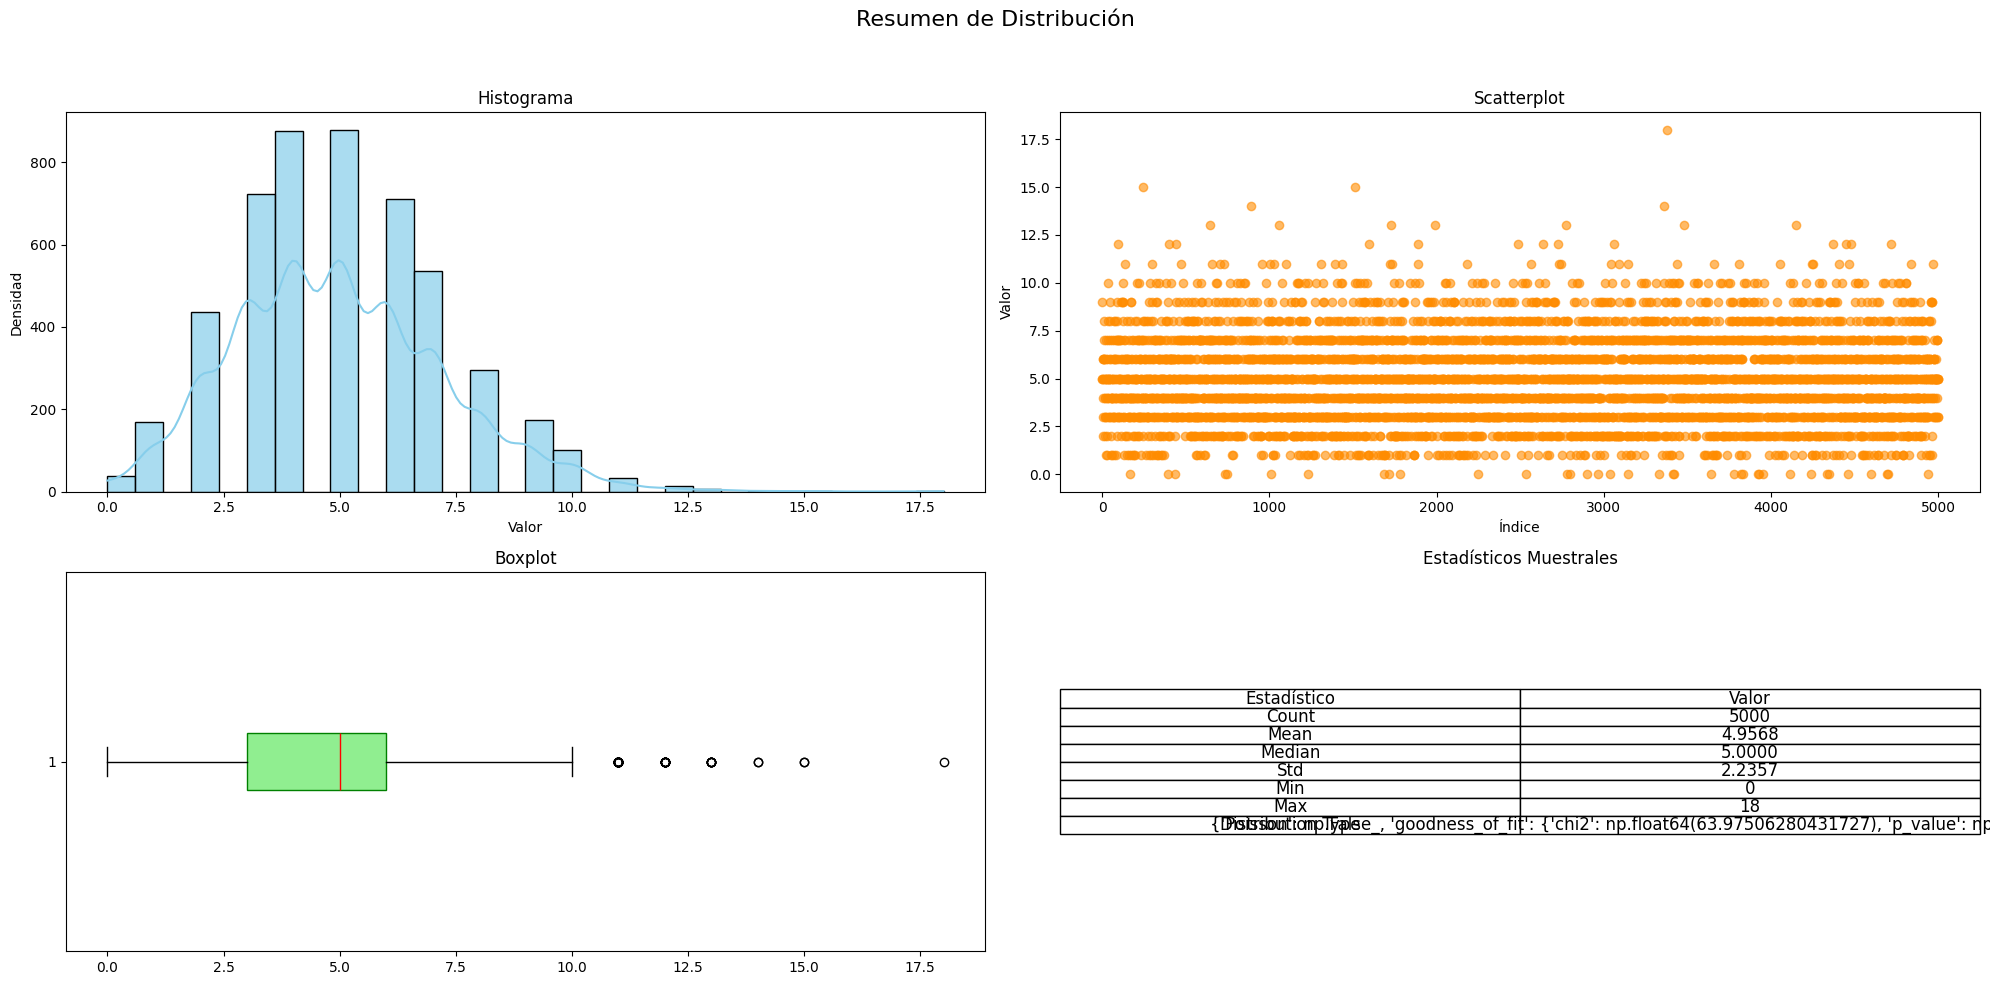

In [143]:
dist.distribution_vizualization()

In [ ]:
waibul = np.random.weibull(a=1, size=1000)
#waibul_test = BootstrapConfidenceIntervals(waibul, alpha=0.05, resamples=10000)
#mean = BootstrapCi(waibul, alpha=0.05, resamples=10000, stat='mean', method='numba')
#mean.calculate_interval()
BootstrapCI(waibul, alpha=0.05, stat='median', method='scipy', n_resamples=100000).compute()['ub']

np.float64(0.7821240890731116)

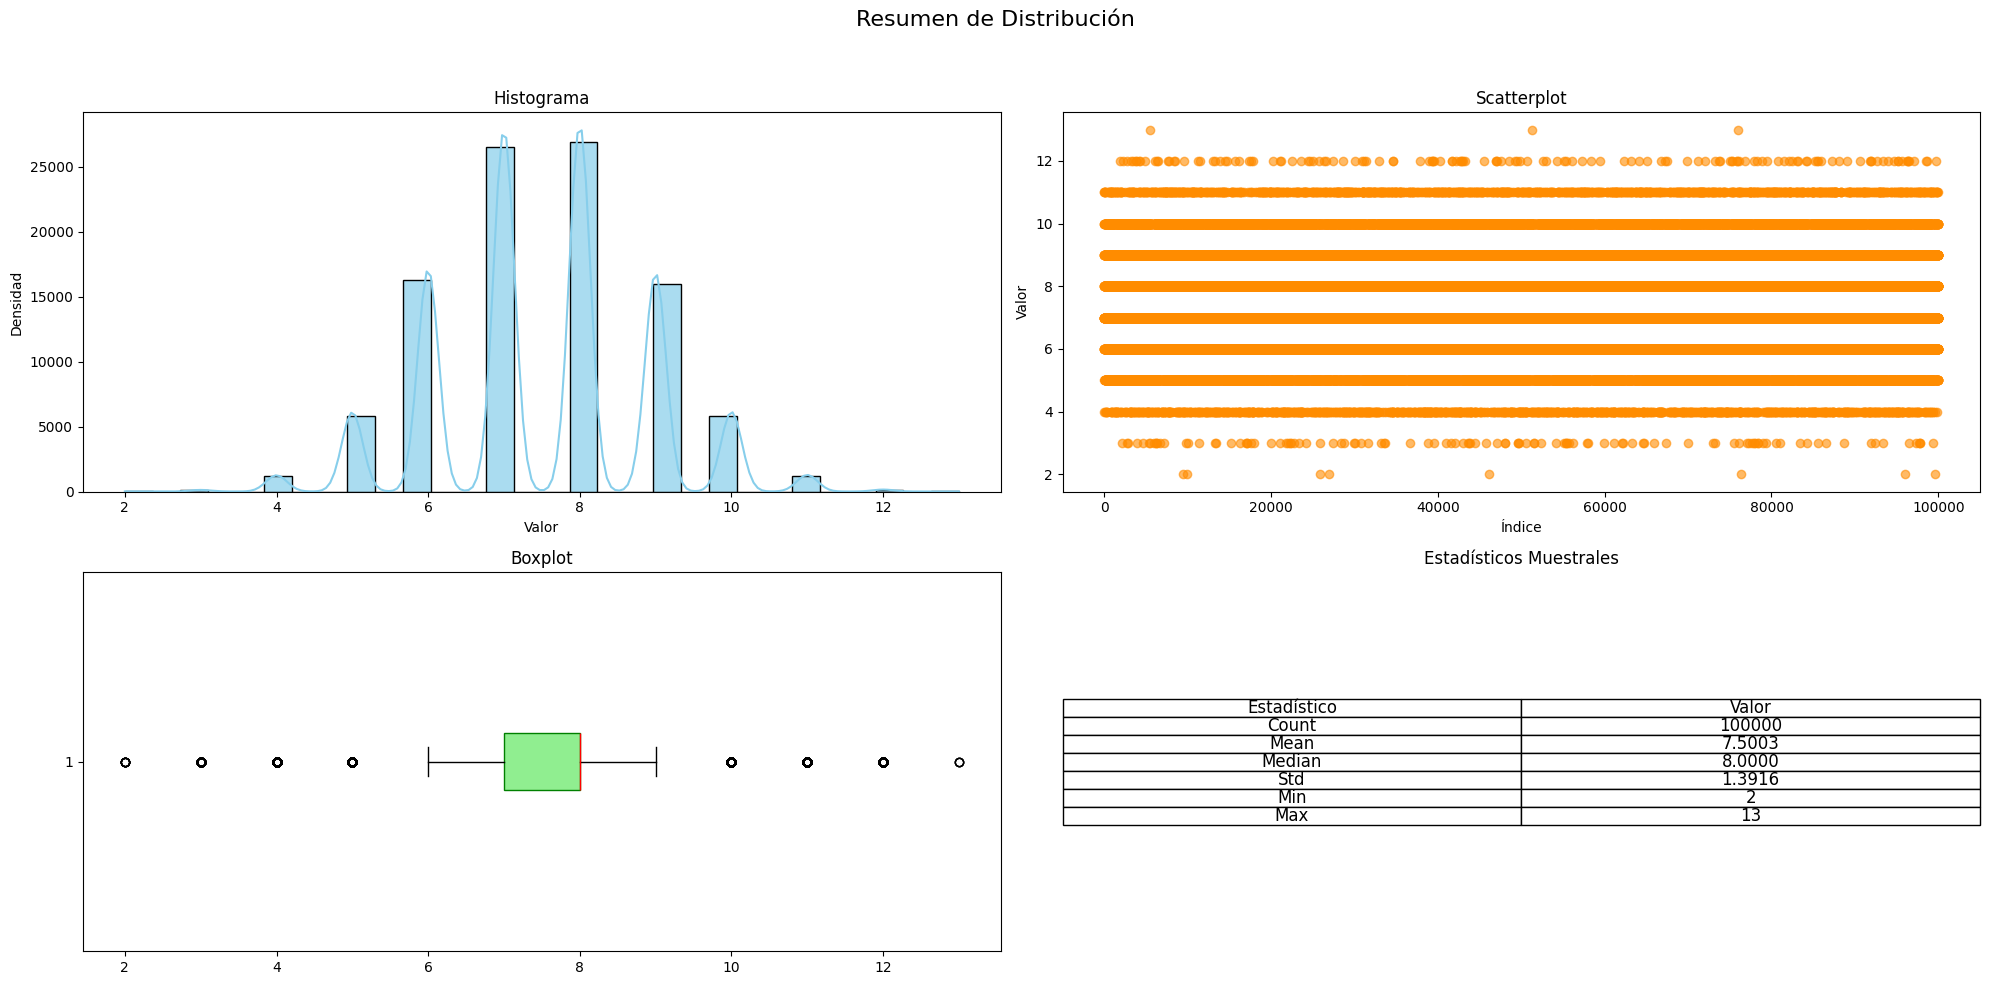

In [ ]:
Distribution(np.random.hypergeometric(15, 15, 15, 100000)).distribution_vizualization()